In [1]:
using ReactiveMP
using Distributions
using Random
using BenchmarkTools
using Rocket
using GraphPPL
using Parameters

Here is an example of creating custom node with nonlinear function approximation with samplelist.

### Custom node creation

In [2]:
struct NonlinearNode end # Dummy structure just to make Julia happy

struct NonlinearMeta{F}
    fn       :: F   # Nonlinear function, we assume 1 float input - 1 float ouput
    nsamples :: Int # Number of samples used in approximation
end

In [3]:
@node NonlinearNode Deterministic [ out, in ]

We need to define two Sum-product message computation rules for our new custom node
- Rule for outbound message on `out` edge given inbound message on `in` edge
- Rule for outbound message on `in` edge given inbound message on `out` edge
- Both rules accept optional meta object

In [4]:
# Rule for outbound message on `out` edge given inbound message on `in` edge
@rule NonlinearNode(:out, Marginalisation) (m_in::NormalMeanVariance, meta::NonlinearMeta) = begin 
    samples = rand(m_in, meta.nsamples)
    return SampleList(map(meta.fn, samples))
end

In [5]:
# Rule for outbound message on `in` edge given inbound message on `out` edge
@rule NonlinearNode(:in, Marginalisation) (m_out::Gamma, meta::NonlinearMeta) = begin     
    return ContinuousUnivariateLogPdf((x) -> logpdf(m_out, meta.fn(x)))
end

### Model specification

After we have defined our custom node with custom rules we may proceed with a model specification. In this model the aim is to estimate a precision of a Gaussian distribution given IID samples. We pass a random variable `θ` through a non-linear transformation `fn` to make it positive and suitable for a precision parameter of a Gaussian distribution. We later on will estimate posterior of `θ`.

In [6]:
@model [ default_factorisation = MeanField() ] function nonlinear_estimation(fn::Function, n, nsamples)
    
    # We fallback to generic product and sample list approximation 
    # with prior as proposal distribution
    θ = randomvar() where {
        prod_constraint = ProdGeneric(),
        form_constraint = SampleListFormConstraint(nsamples, LeftProposal()) 
    }
    
    θ ~ NormalMeanVariance(0.0, 100.0)
    m ~ NormalMeanVariance(0.0, 1.0)
    
    # We fallback to generic product and sample list approximation 
    # with likelihood as proposal distribution
    w = randomvar() where {
        prod_constraint = ProdGeneric(),
        form_constraint = SampleListFormConstraint(nsamples, RightProposal()) 
    }
    
    w ~ NonlinearNode(θ) where { meta = NonlinearMeta(fn, nsamples) }
    
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanPrecision(m, w)
    end
    
    return θ, m, w, y
end

nonlinear_estimation (generic function with 1 method)

Here we generate some data

In [10]:
function nonlinear_fn(x) # We use exp as a simple example
    return exp(x + 2)
end

nonlinear_fn (generic function with 1 method)

In [11]:
seed = 123
rng  = MersenneTwister(seed)

niters   = 15 # Number of VMP iterations
nsamples = 5_000 # Number of samples in approximation

n = 1000 # Number of IID samples
μ = -10.0
θ = -3.0
w = nonlinear_fn(θ)


data = rand(rng, NormalMeanPrecision(μ, w), n);

In [33]:
@time result = inference(model=() -> nonlinear_estimation(nonlinear_fn, n, nsamples), 
                         data=Dict(:y => data), 
                         initmarginals=Dict(:m => vague(NormalMeanPrecision), :w => vague(Gamma)),
                         iterations=niters, showprogress=true);

θposterior = result.posteriors[:θ];

  0.194140 seconds (710.40 k allocations: 46.054 MiB, 67.63% compilation time)


In [34]:
using CairoMakie

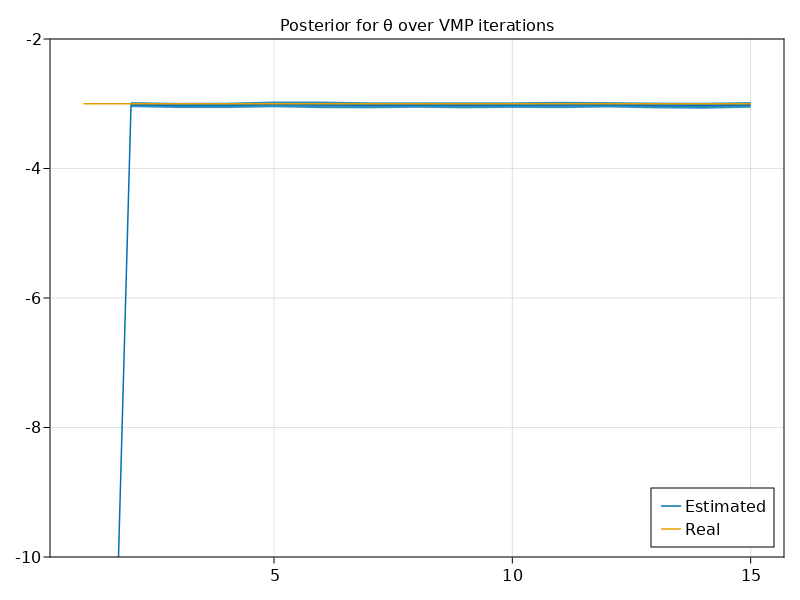

In [35]:
let
    f = Figure()
    
    θplot = Axis(f[1, 1])
    
    θplot.title = "Posterior for θ over VMP iterations"
    
    range = 1:niters
    
    lines!(θplot, range, mean.(θposterior), label = "Estimated")
    band!(θplot, range, mean.(θposterior) .- std.(θposterior), mean.(θposterior) .+ std.(θposterior))
    
    lines!(θplot, range, fill(θ, niters), label = "Real")
    
    axislegend(θplot, position = :rb)
    
    ylims!(θplot, (-10, -2))
    
    f
end

In [36]:
@benchmark inference(model=() -> nonlinear_estimation($nonlinear_fn, $n, $nsamples), 
                     data=Dict(:y => $data), 
                     initmarginals=Dict(:m => vague(NormalMeanPrecision), :w => vague(Gamma)),
                     iterations=$niters, showprogress=true)

BenchmarkTools.Trial: 79 samples with 1 evaluation.
 Range (min … max):  49.312 ms … 107.985 ms  ┊ GC (min … max):  0.00% … 29.43%
 Time  (median):     57.315 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   64.450 ms ±  15.041 ms  ┊ GC (mean ± σ):  12.53% ± 15.13%

    ▂ ▃▃█                                                       
  ▇▇█▅███████▁▅▄▄▅▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▄▄▅▇▅▄▁▇▇▁▄▄▄▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▄ ▁
  49.3 ms         Histogram: frequency by time          106 ms <

 Memory estimate: 40.38 MiB, allocs estimate: 615658.

In [32]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.6.0)
  CPU: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
